## Qualitative effect of the profile in no canyon case


In [1]:
import gsw 

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt 

In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [4]:
# Define experiment paths

#CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)
CState = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/stateGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CPtracers = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc' # Smallest volume grid, closed bdy, no canyon.


In [5]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 8 # number of tracers in run

rc = CGridOut.variables['RC']
xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

rA = rout.getField(CGrid, 'rA')

drF = CGridOut.variables['drF'] # vertical distance between faces
drC = CGridOut.variables['drC'] # vertical distance between centers

depth = rout.getField(CGrid, 'Depth')

hFacC = rout.getField(CGrid, 'HFacC')
MaskC = rout.getMask(CGrid, 'HFacC')

labels = ['Linear','Salt','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

# Physical constants
g = 9.81 # m/s^2



In [6]:
def get_iniProfile(exp, run, TrNum, key):
    '''Get column from the pandas dataframe containing initial profiles using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI), TrNum (1,2,3, etc). All input variables are strings.
    Returns the desired column from the dataframe.'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%siniTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col

def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


In [7]:
def plot_CSTr(TrMask,yc,rc, zfin,xh1,xh2,tt):
    '''Make plots to see what the tracer along-shelf integrated tracer concentration is.'''
    
    fig46=plt.figure(figsize=(22,12))
    sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1.1,rc={"lines.linewidth": 1.5})

    HH =TrMask[:,:zfin,yh1:300,xh1:xh2]
    SS = TrMask[:,:zfin,yin:,:]
    
    HHsum = TrMask[tt,:,:,180]
    SSsum = TrMask[tt,:zfin,yin:,180]

    HHsum0 = TrMask[0,:,:,180]
    SSsum0 = TrMask[0,:zfin,yin:,180]
    
    vmax1 = np.max(HHsum[:,:]-HHsum0[:,:])
    vmax2 = np.max(SSsum[:,:]-SSsum0[:,:])
    
    plt.subplot(2,3,1)
    plt.pcolor(yc[:,0]/1000,rc[:],HHsum[:,:],cmap='rainbow')
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.title('Tr concentration at t=%1.1f days' %(tt/2.0))

    plt.subplot(2,3,4)
    plt.xlabel('Cross-shore distance (km)')
    plt.pcolor(yc[yin:,180]/1000,rc[:zfin],SSsum[:,:],cmap='rainbow')
    plt.colorbar()
    plt.ylabel('depth (m)')

    plt.subplot(2,3,2)
    plt.pcolor(yc[:,0]/1000,rc[:],HHsum[:,:]-HHsum0[:,:],cmap='RdYlBu_r',vmax=vmax1, vmin=-vmax1)
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.title('$\Delta Tr$ ($Tr-Tr_0$)')


    plt.subplot(2,3,5)
    plt.pcolor(yc[yin:,180]/1000,rc[:zfin],SSsum[:,:]-SSsum0[:,:],cmap='RdYlBu_r',vmax = vmax2,vmin=-vmax2)
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.xlabel('Cross-shore distance (km)')

    plt.subplot(2,3,3)
    plt.title('Depth integrated $\Delta Tr$ ($Tr-Tr_0$)')
    plt.plot(yc[:,0]/1000,np.sum(HHsum[:,:],axis=0)-np.sum(HHsum0[:,:],axis=0))
    plt.ylabel('$\Delta$ Tracer concentration ')

    plt.subplot(2,3,6)
    plt.plot(yc[yin:,180]/1000,np.sum(SSsum[:,:],axis=0)-np.sum(SSsum0[:,:],axis=0))
    plt.xlabel('Cross-shore distance (km)')
    plt.ylabel('$\Delta$ Tracer concentration ')


In [47]:
def plot_CSLinAnom(TrMask,TrMaskLin,yc,rc, zfin,xh1,xh2,tt,TrName):
    '''Make plots to see what the tracer along-shelf integrated tracer concentration minus linear case is.'''
    
    fig46=plt.figure(figsize=(25,12))
    sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1.1,rc={"lines.linewidth": 2})

    HH =TrMask[:,:zfin,yh1:300,xh1:xh2]
    SS = TrMask[:,:zfin,yin:,:]
    
    HHLin =TrMaskLin[:,:zfin,yh1:300,xh1:xh2]
    SSLin = TrMaskLin[:,:zfin,yin:,:]
    
    HHsum = TrMask[tt,:,:,180]
    SSsum = TrMask[tt,:zfin,yin:,180]

    HHsum0 = TrMask[0,:,:,180]
    SSsum0 = TrMask[0,:zfin,yin:,180]
    
    HHLinsum = TrMaskLin[tt,:,:,180]
    SSLinsum = TrMaskLin[tt,:zfin,yin:,180]

    HHLinsum0 = TrMaskLin[0,:,:,180]
    SSLinsum0 = TrMaskLin[0,:zfin,yin:,180]
    
    vmax1 = np.max(HHsum[:,:]-HHsum0[:,:])
    vmax2 = np.max(SSsum[:,:]-SSsum0[:,:])
    
    #vmax3 = np.max((HHsum[:,:]-HHLinsum[:,:])/(HHSum0[:,:]-HHLinsum0[:,:]))
    #vmax4 = np.max((SSsum[:,:]-SSLinsum[:,:])/(SSsum0[:,:]-SSLinsum0[:,:]))
    
    plt.subplot(2,3,1)
    plt.pcolor(yc[:,0]/1000,rc[:],HHsum[:,:]-HHsum0[:,:],cmap='RdYlGn_r', vmax=vmax1, vmin =-vmax1 )
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.title('$\Delta Tr$ ($Tr-Tr_0$), t=%1.1f days' %(tt/2.0))

    plt.subplot(2,3,4)
    plt.xlabel('Cross-shore distance (km)')
    plt.pcolor(yc[yin:,180]/1000,rc[:zfin],SSsum[:,:]-SSsum0[:,:],cmap='RdYlGn_r', vmax=vmax2, vmin =-vmax2 )
    plt.colorbar()
    plt.ylabel('depth (m)')

    plt.subplot(2,3,2)
    plt.pcolor(yc[:,0]/1000,rc[:],(HHsum[:,:]-HHLinsum[:,:])/(HHsum0[:,:]-HHLinsum0[:,:]),cmap='RdYlGn_r')#, vmax=vmax3, vmin =-vmax3 )
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.title(' $(Tr-Tr_{Lin})/(Tr_0-Tr_{Lin0})$ ')

    plt.subplot(2,3,5)
    plt.pcolor(yc[yin:,180]/1000,rc[:zfin],(SSsum[:,:]-SSLinsum[:,:])/(SSsum0[:,:]-SSLinsum0[:,:]),cmap='RdYlGn_r')#, vmax=vmax4, vmin =-vmax4 )
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.xlabel('Cross-shore distance (km)')

    plt.subplot(2,3,3)
    plt.title('Depth integrated $\Delta Tr$ ($Tr-Tr_0$)')
    #plt.plot(yc[:,0]/1000,np.sum(HHsum[:,:],axis=0)-np.sum(HHsum0[:,:],axis=0), label=('%s' %TrName))
    #plt.plot(yc[:,0]/1000,np.sum(HHLinsum[:,:],axis=0)-np.sum(HHLinsum0[:,:],axis=0),label='Linear')
    plt.plot(yc[:,0]/1000,np.sum((HHsum[:,:]-HHLinsum[:,:])/(HHsum0[:,:]-HHLinsum0[:,:]),axis=0),label='Linear')
    
    plt.ylabel('$\Delta$ Tracer concentration ')

    plt.subplot(2,3,6)
    #plt.plot(yc[yin:,180]/1000,np.sum(SSsum[:,:],axis=0)-np.sum(SSsum0[:,:],axis=0),label=('%s' %TrName))
    plt.plot(yc[yin:,180]/1000,np.sum((SSsum[:,:]-SSLinsum[:,:])/(SSsum0[:,:]-SSLinsum0[:,:]),axis=0),label = 'Linear')
    plt.legend(loc=0)
    plt.xlabel('Cross-shore distance (km)')
    plt.ylabel('$\Delta$ Tracer concentration ')


In [9]:
# Load passive tracers

Tr1 = rout.getField(CPtracers, 'Tr01')
Tr2 = rout.getField(CPtracers, 'Tr02')
Tr3 = rout.getField(CPtracers, 'Tr03')
Tr4 = rout.getField(CPtracers, 'Tr04')
Tr5 = rout.getField(CPtracers, 'Tr05')
Tr6 = rout.getField(CPtracers, 'Tr06')
Tr7 = rout.getField(CPtracers, 'Tr07')
Tr8 = rout.getField(CPtracers, 'Tr08')


In [10]:
# Masking of tracers

maskExp = mpt.maskExpand(MaskC,Tr1)

Tr1Mask = np.ma.array(Tr1,mask=maskExp)   
Tr2Mask = np.ma.array(Tr2,mask=maskExp)   
Tr3Mask = np.ma.array(Tr3,mask=maskExp)   
Tr4Mask = np.ma.array(Tr4,mask=maskExp)   
Tr5Mask = np.ma.array(Tr5,mask=maskExp)   
Tr6Mask = np.ma.array(Tr6,mask=maskExp)   
Tr7Mask = np.ma.array(Tr7,mask=maskExp)   
Tr8Mask = np.ma.array(Tr8,mask=maskExp)   



In [11]:
# active tracers

#Temp = rout.getField(CState,'Temp')
#S = rout.getField(CState,'S')

#TempMask=np.ma.array(Temp,mask=maskExp)   
#SMask=np.ma.array(S,mask=maskExp)   


In [12]:
# Input for plotting cross-sections

nzlim = 30
yin = 227
zfin = 30
xi = 180
yi = 50
xh1=120
xh2=240
yh1=227
yh2=267


## Linear profile

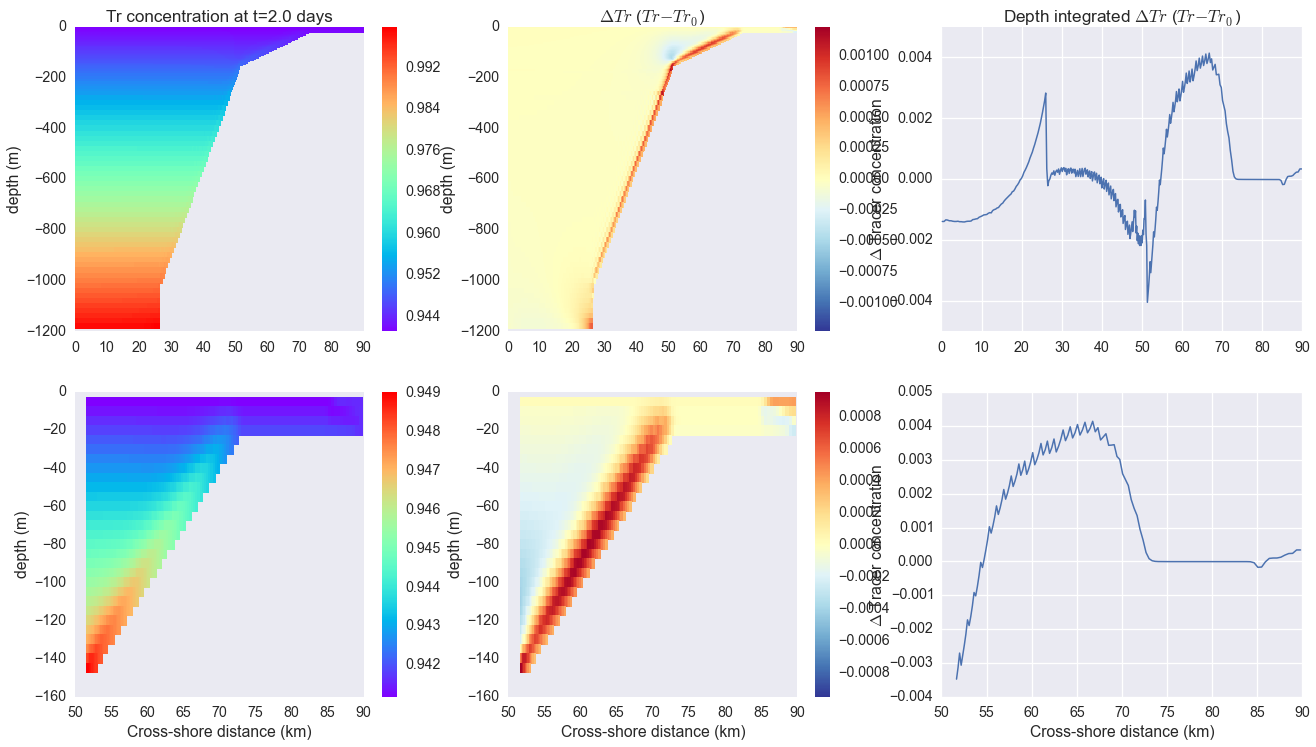

In [13]:
Tr1Norm = Tr1Mask/np.max(Tr1Mask[0,:,:,:])

plot_CSTr(Tr1Norm,yc,rc, zfin,xh1,xh2,4)

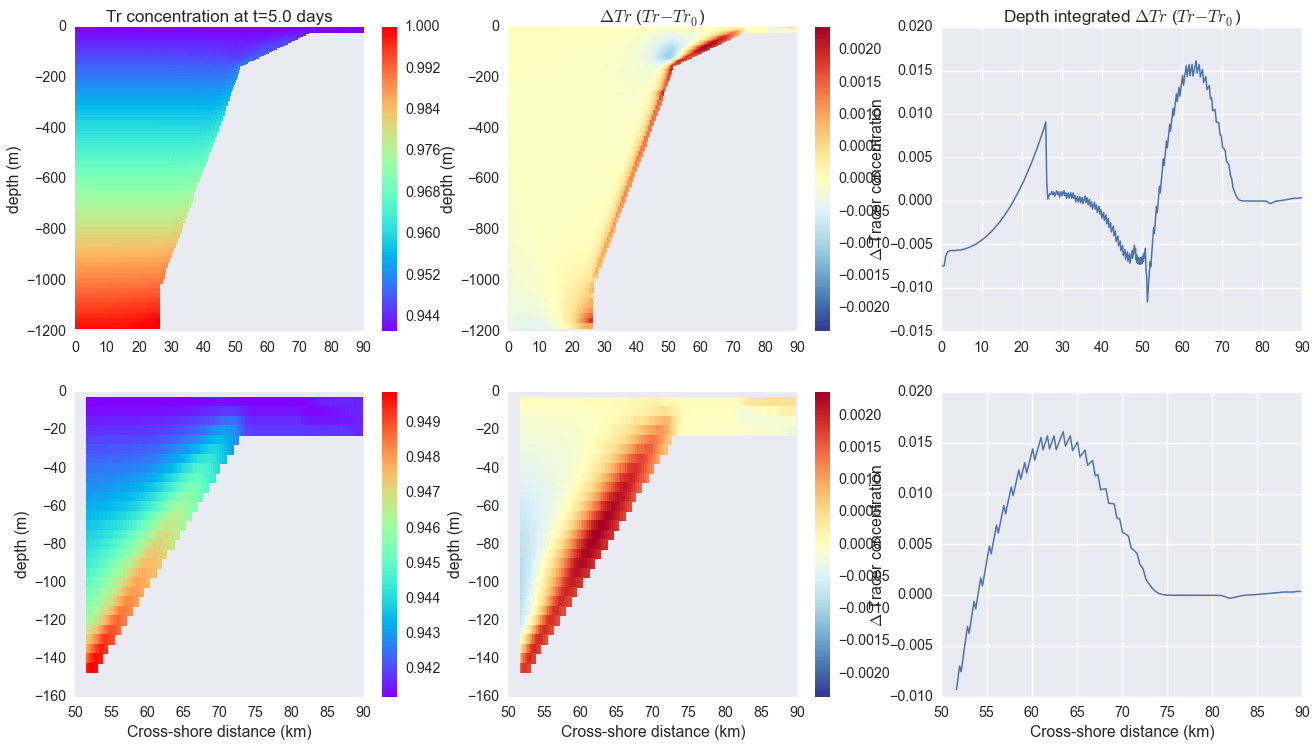

In [14]:
plot_CSTr(Tr1Norm,yc,rc, zfin,xh1,xh2,10)

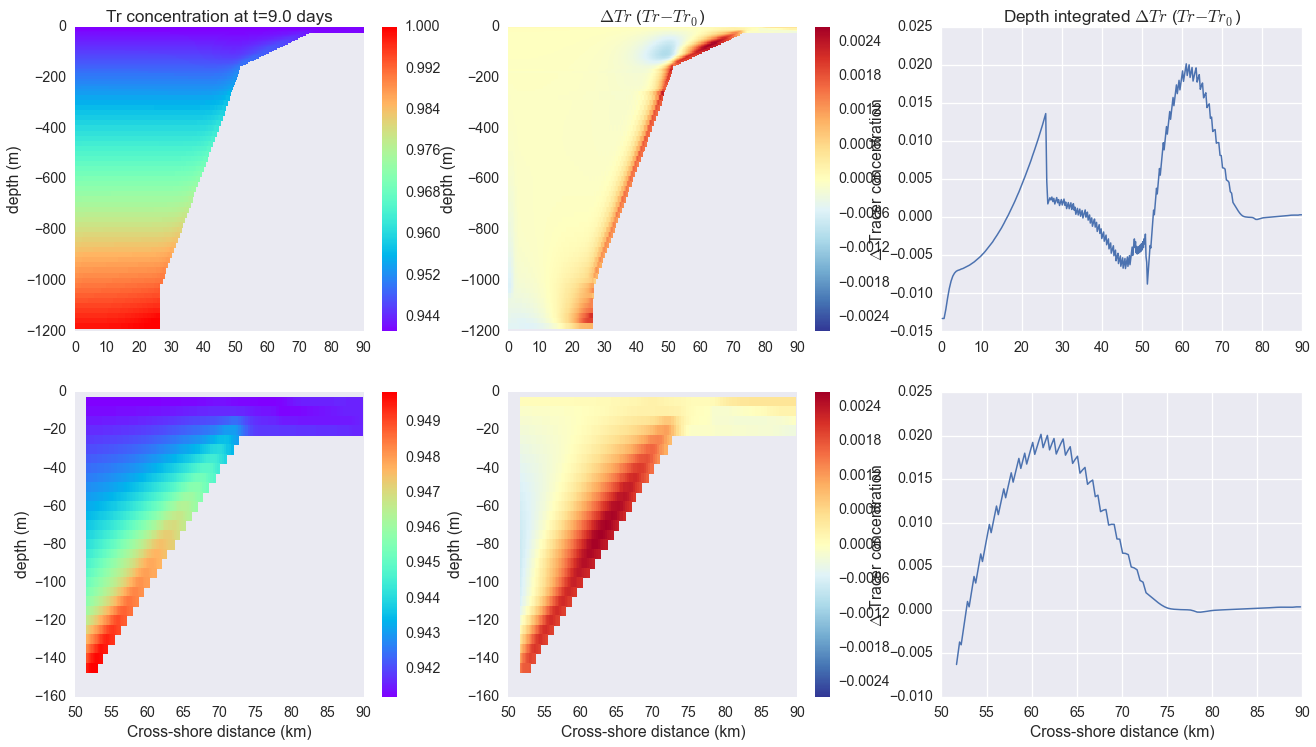

In [15]:
plot_CSTr(Tr1Norm,yc,rc, zfin,xh1,xh2,18)

## Difference between profiles and linear profile

Since linear is the simplest case in which high-concentration water comes up to the shelf, it will be used as the base case and deviations of the other concentration fronts from that behaviour will be discussed in what follows.

The deviation is defined as $$$$

### Salinity profile

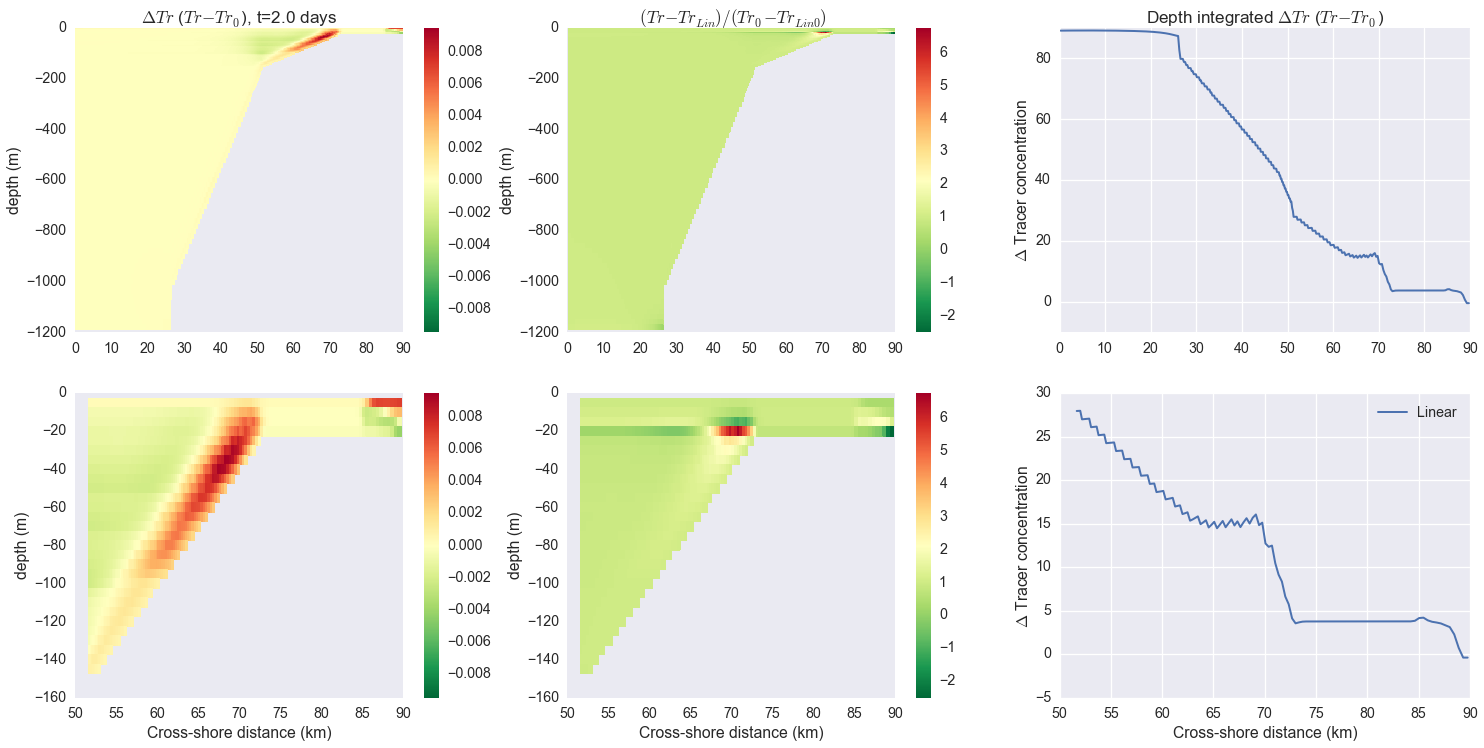

In [48]:
Tr2Norm = Tr2Mask/np.max(Tr2Mask)

plot_CSLinAnom(Tr2Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,4,'Salinity')

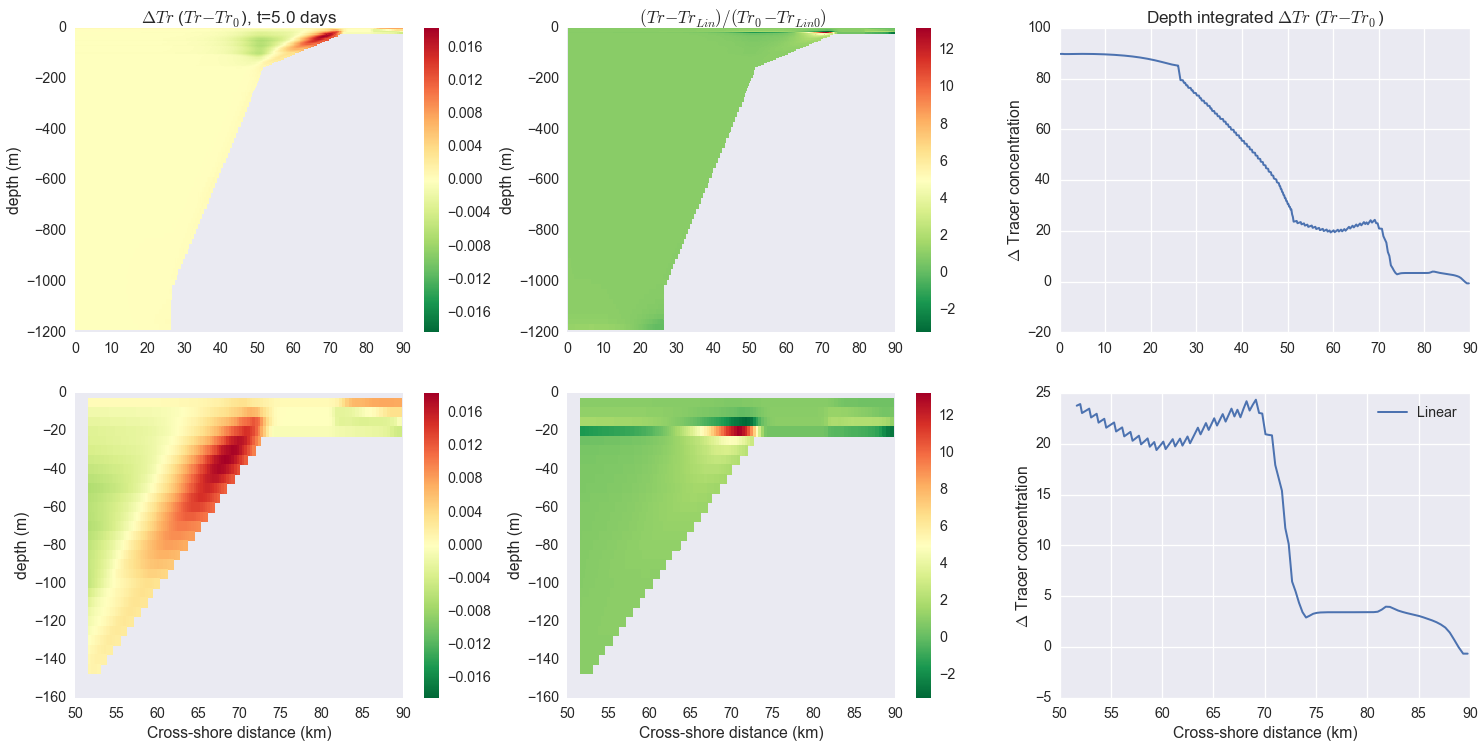

In [49]:
plot_CSLinAnom(Tr2Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,10,'Salinity')

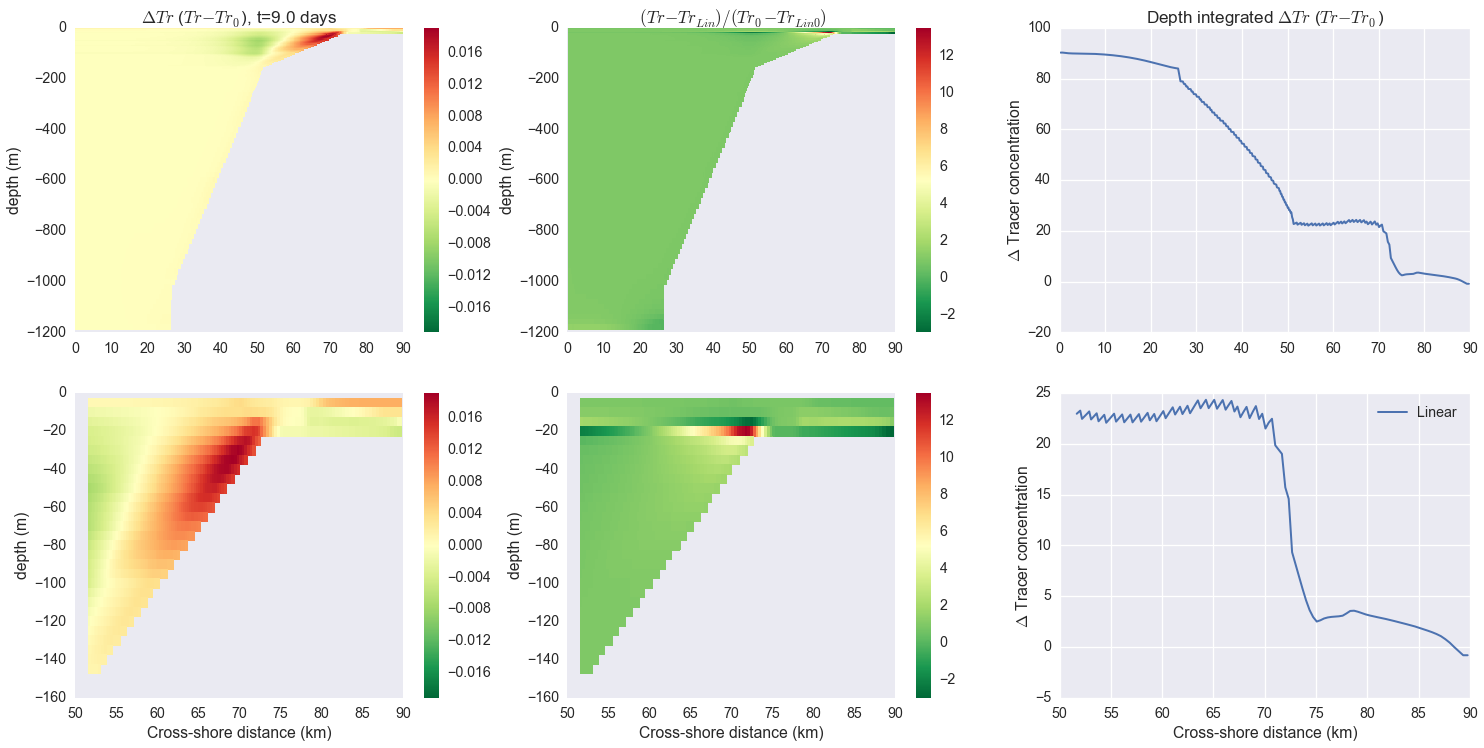

In [50]:
plot_CSLinAnom(Tr2Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,18,'Salinity')

## Oxygen profile


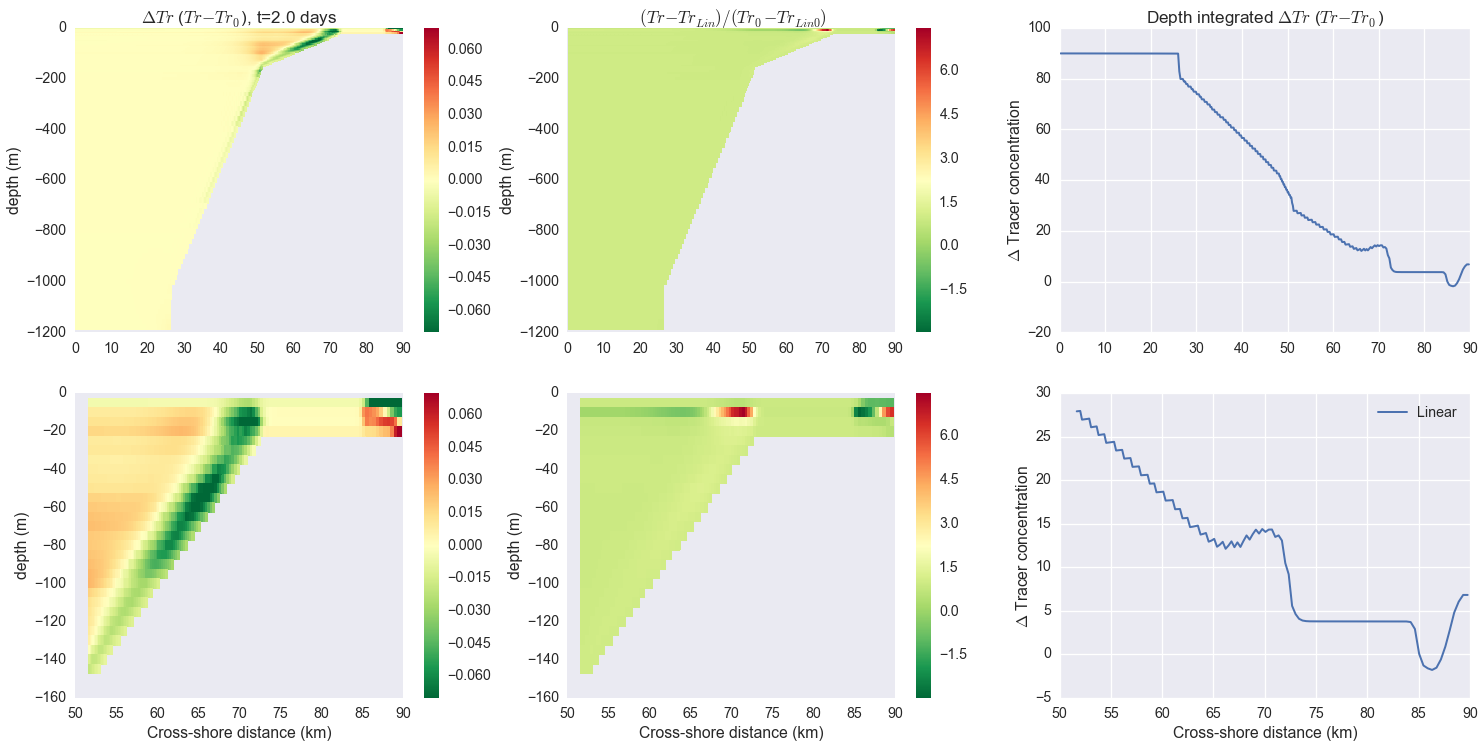

In [51]:
Tr3Norm = Tr3Mask/np.max(Tr3Mask)

plot_CSLinAnom(Tr3Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,4,'Oxygen')

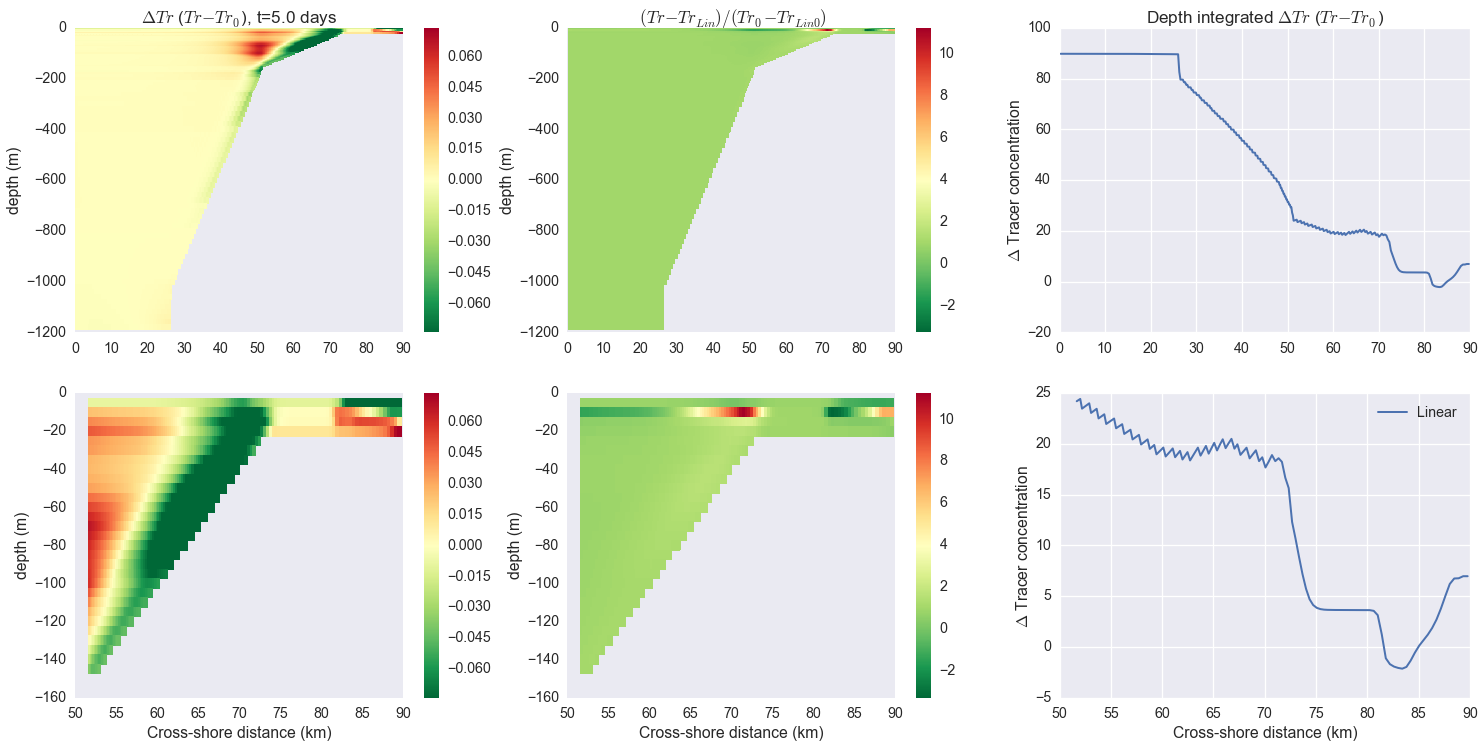

In [52]:
plot_CSLinAnom(Tr3Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,10,'Oxygen')

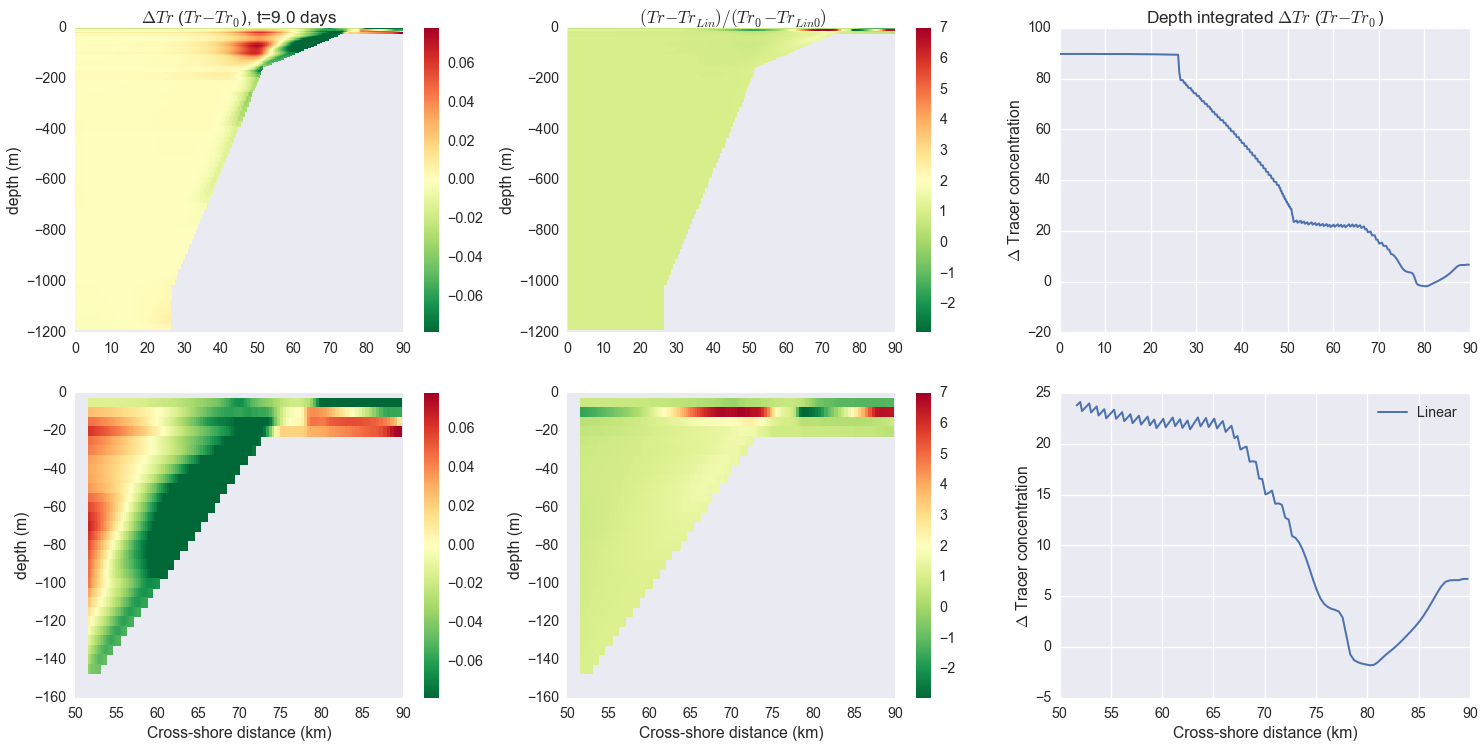

In [53]:
plot_CSLinAnom(Tr3Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,18,'Oxygen')

## Nitrate 

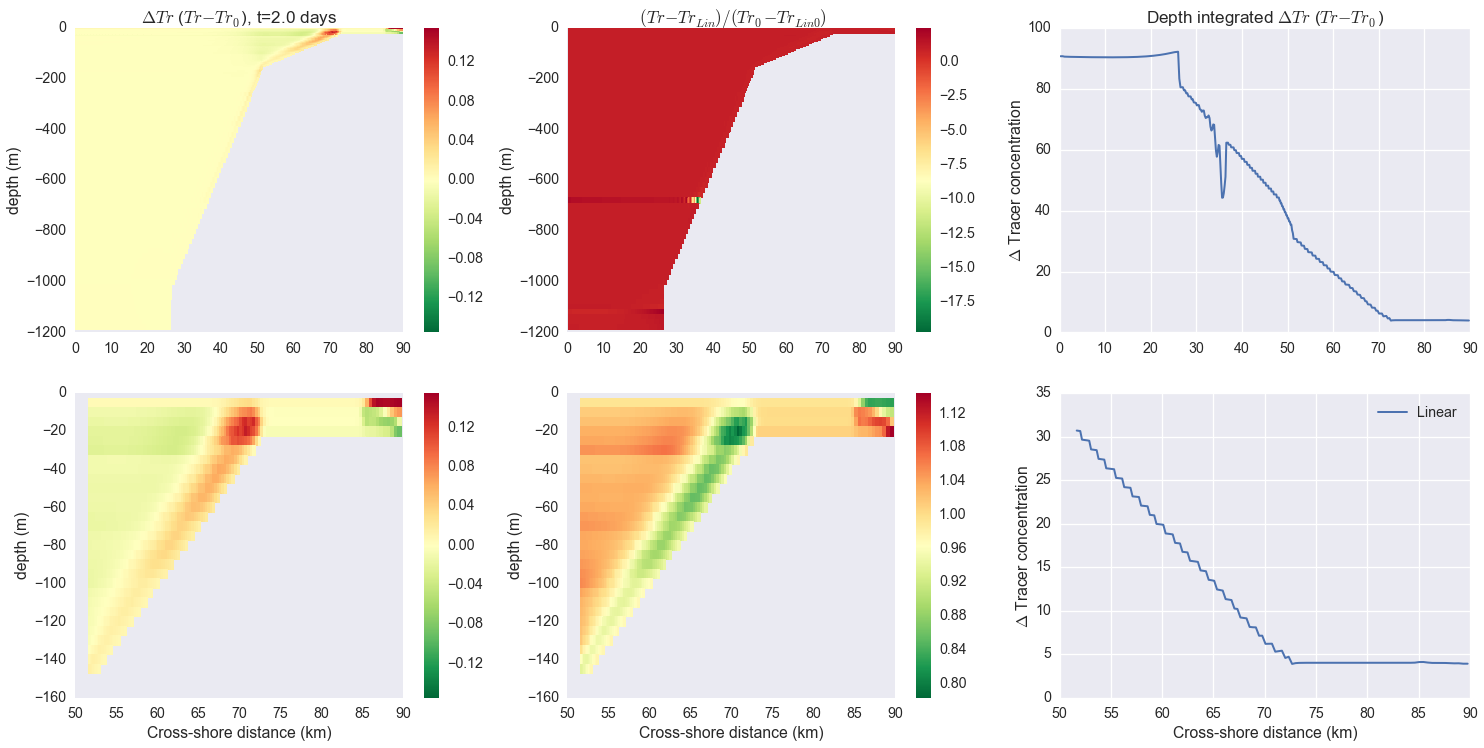

In [54]:
Tr4Norm = Tr4Mask/np.max(Tr4Mask)

plot_CSLinAnom(Tr4Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,4,'Nitrate')

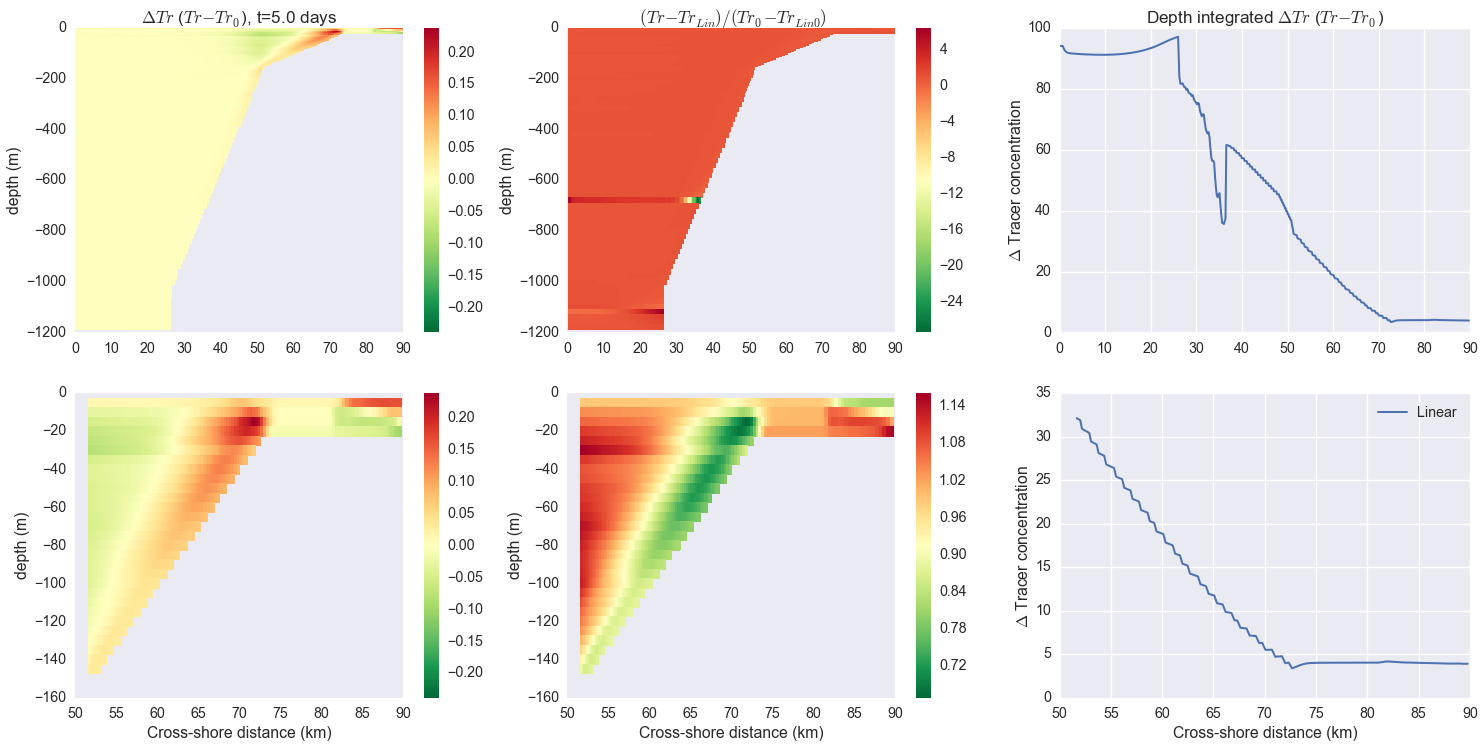

In [58]:
plot_CSLinAnom(Tr4Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,10,'Nitrate')

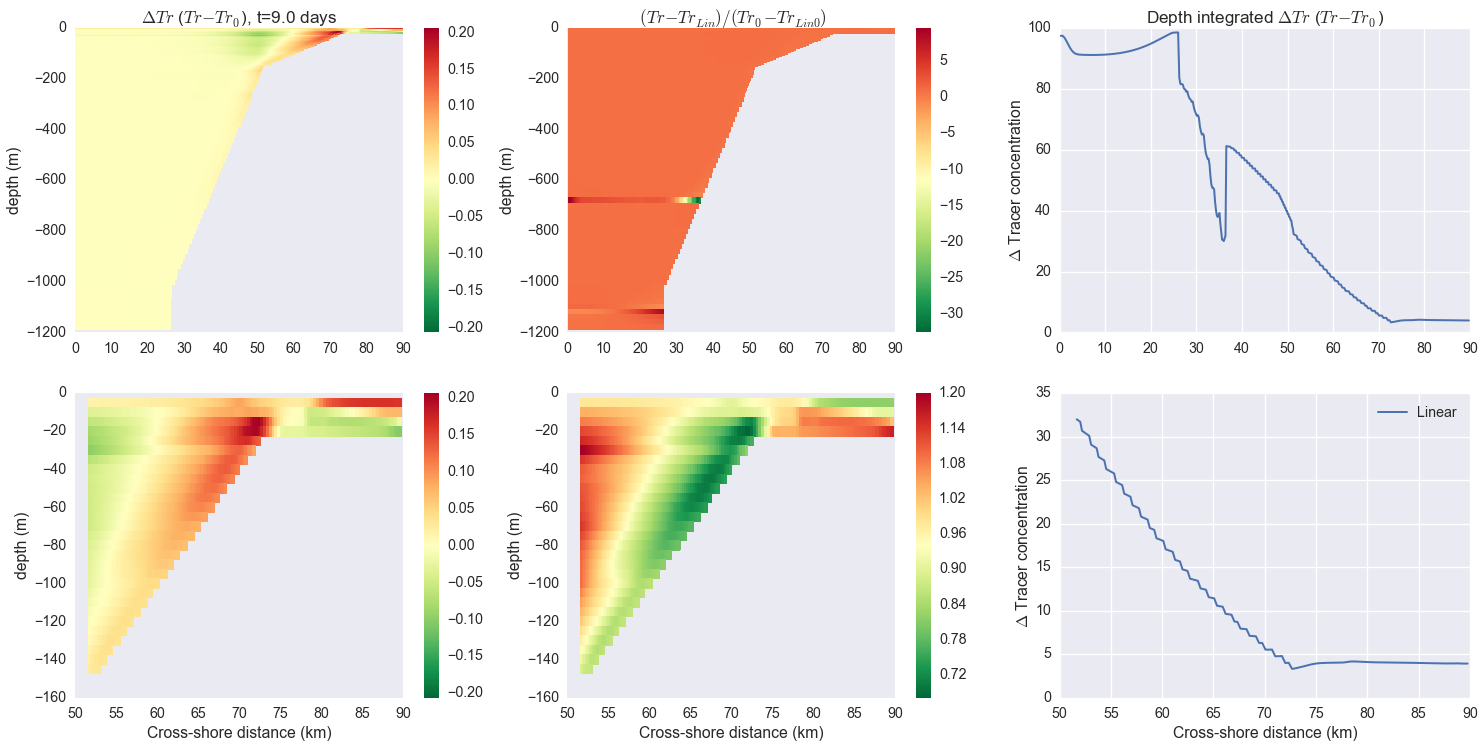

In [59]:
plot_CSLinAnom(Tr4Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,18,'Nitrate')

## Methane

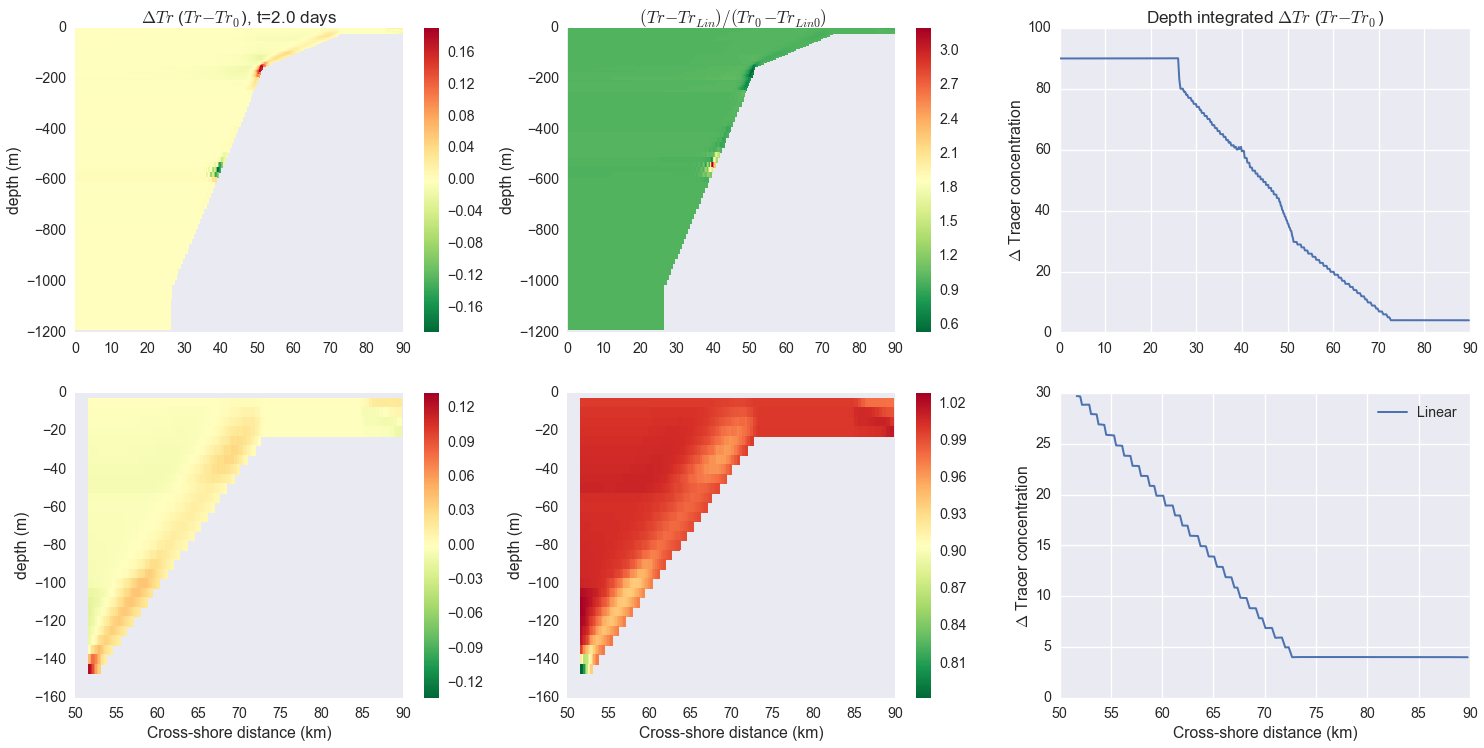

In [60]:
Tr8Norm = Tr8Mask/np.max(Tr4Mask)

plot_CSLinAnom(Tr8Norm,Tr1Norm,yc,rc, zfin,xh1,xh2,4,'Methane')